In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import shutil

import wfdb
from wfdb import processing

%matplotlib inline

## Reading records and annotations

In [2]:
record_id = 'I01'
segment_len = 2000
start=2000
end=start+segment_len
record_path = '../incartDb/'+record_id

In [3]:
# Read a wfdb record using the 'rdrecord' function into a wfdb.Record object.
# Plot the signals, and show the data.
#record = wfdb.rdrecord(record_path, sampfrom=start, sampto=end) 
#wfdb.plot_wfdb(record=record, annotation=annotation,
#               title='Record I01',
#               time_units='seconds', figsize=(10,20))
#print(record.__dict__)

signal, fields = wfdb.rdsamp(record_path, sampfrom=start, sampto=end, channels=[0,9]) 
data = np.mean(signal, axis=1)
fs = fields['fs']

## Write record into .csv file

In [4]:
time = np.linspace(0, segment_len/fs, segment_len)
print(len(time))
time

2000


array([0.00000000e+00, 3.89299708e-03, 7.78599416e-03, ...,
       7.77431517e+00, 7.77820817e+00, 7.78210117e+00])

In [5]:
file = pd.DataFrame()
file['timestamp'] = time
file['ecg_measurement'] = data
file

,timestamp,ecg_measurement
0,0.000000,-0.328431
1,0.003893,-0.336601
2,0.007786,-0.343137
3,0.011679,-0.361111
4,0.015572,-0.338235
5,0.019465,-0.316993
6,0.023358,-0.328431
7,0.027251,-0.328431
8,0.031144,-0.325163
9,0.035037,-0.336601


In [6]:
file_name = '../tmp/incartDb_' + record_id + '_' + str(start) + '.csv'
file.to_csv(file_name, index=False)

## Peak detection with `qrs_detector` from c-labpl

In [7]:
import sys
sys.path.insert(0, '/home/singuyen/Study/biosignal/project/c-labpl.qrs_detector.master')

from QRSDetectorOffline import QRSDetectorOffline

qrs peaks indices
[  87  246  405  565  893 1053 1212 1373 1531 1689 1849]
noise peaks indices
[]


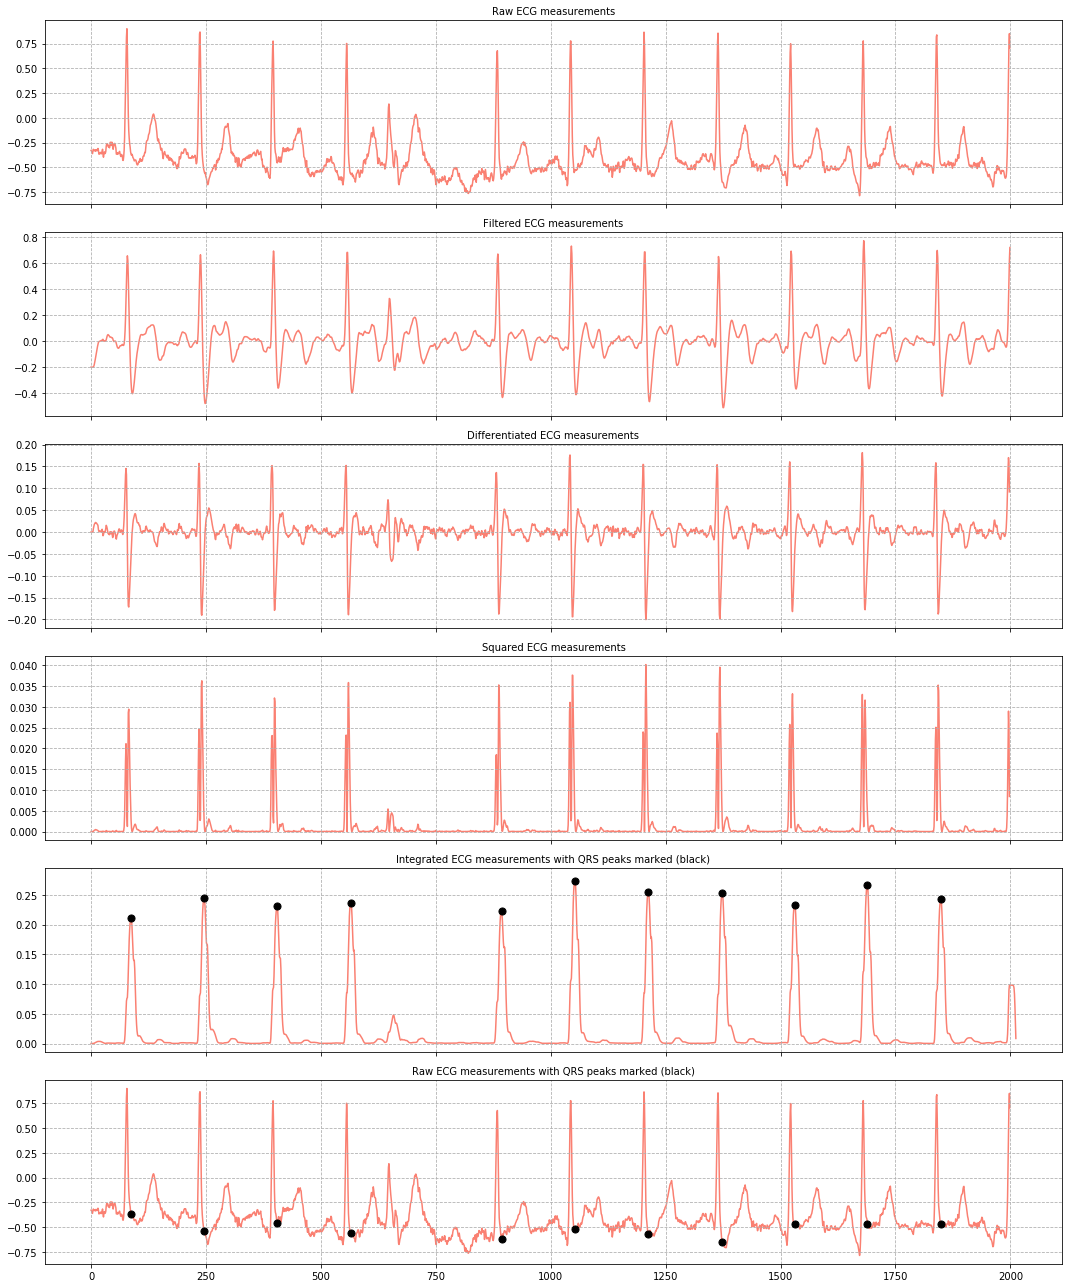

In [8]:
qrs_detector = QRSDetectorOffline(ecg_data_path=file_name, fs=fs, 
                                  findpeaks_limit=0.2, findpeaks_spacing_factor=0.2,
                                  verbose=True,
                                  log_data=True, plot_data=True, show_plot=True)

In [9]:
qrs_detector.detected_peaks_indices

array([  87,  246,  405,  565,  893, 1053, 1212, 1373, 1531, 1689, 1849])

## Validation

In [10]:
detected_inds = qrs_detector.qrs_peaks_indices
detected_inds

array([  87,  246,  405,  565,  893, 1053, 1212, 1373, 1531, 1689, 1849])

In [11]:
detected_inds + start

array([2087, 2246, 2405, 2565, 2893, 3053, 3212, 3373, 3531, 3689, 3849])

In [12]:
annotation = wfdb.rdann(record_path, 'atr', sampfrom=start, sampto=end)
annotation.sample

array([2076, 2237, 2393, 2557, 2656, 2885, 3042, 3203, 3363, 3521, 3681,
       3839, 3998])

In [13]:
# Compare detected qrs complexes to reference annotation.
comparitor = processing.compare_annotations(ref_sample = annotation.sample,
                                            test_sample = detected_inds+start,
                                            window_width = int(0.1 * fs),
                                            signal = signal)

# Print the results
comparitor.print_summary()

13 reference annotations, 11 test annotations

True Positives (matched samples): 11
False Positives (unmatched test samples: 0
False Negatives (unmatched reference samples): 2

Specificity: 0.8462 (11/13)
Positive Predictivity: 1.0000 (11/11)
False Positive Rate: 0.0000 (0/11)
